# Final project

## Import dependencies

In [2]:
# Imports
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from math import pi, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Load Lisbon data

In [1]:
# Load data
#url=r'/resources/data/Lisbon/Lisbon_data.csv'
url=r'https://raw.githubusercontent.com/luishmd/Lisbon-boroughs-price-predictor/master/data/Lisbon_data.csv'
df_lisbon = pd.read_csv(url,sep=',')
df_lisbon

NameError: name 'pd' is not defined

## Create Lisbon neighborhood map

In [3]:
address = 'Lisbon, Portugal'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Lisbon are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Lisbon are 38.7077507, -9.1365919.


In [4]:
# create map of Lisbon using latitude and longitude values
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_lisbon['Latitude'], df_lisbon['Longitude'], df_lisbon['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)
    
map_lisbon


## Extract neighborhoods venue's info

### Get Foursquare credentials and version

In [5]:
CLIENT_ID = 'PL5DQL5YRMC2QBLRDIXGEEE531PYENZVATQQYYKHUHKRMPAJ' # your Foursquare ID
CLIENT_SECRET = 'EP2ODJ3IG2CRWZS2E2VXC1N1JX0YV4VA351U3TUTSOBTQELT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PL5DQL5YRMC2QBLRDIXGEEE531PYENZVATQQYYKHUHKRMPAJ
CLIENT_SECRET:EP2ODJ3IG2CRWZS2E2VXC1N1JX0YV4VA351U3TUTSOBTQELT


### Determine radius for search

In [6]:
# Assumes a circle
A_min = df_lisbon['Area (km2)'].min()
r_min = sqrt(A_min / 3.14159)*1000 # m
r_min

688.6814437915589

### Extract venue info

In [7]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = r_min # define radius (m)

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Processing: {}".format(name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
do_backup = False
# Using backup to avoid results changing due to daily Foursquare updates
use_backup = True

if not use_backup:
    print('Querying Foursquare...')
    lisbon_venues = getNearbyVenues(names=df_lisbon['Neighborhood'],
                                       latitudes=df_lisbon['Latitude'],
                                       longitudes=df_lisbon['Longitude'])
else:
    #    url=r'/resources/data/Lisbon/Lisbon_backup.csv'
    print('Restoring backup...')
    url=r'https://raw.githubusercontent.com/luishmd/Lisbon-boroughs-price-predictor/master/data/Lisbon_backup.csv'
    lisbon_venues = pd.read_csv(url,sep=',')
    print('Completed.')

if do_backup:
    #    url=r'/resources/data/Lisbon/Lisbon_backup.csv'
    url=r'https://raw.githubusercontent.com/luishmd/Lisbon-boroughs-price-predictor/master/data/Lisbon_backup.csv'  
    lisbon_venues.to_csv(url,sep=',', index=False)
    print('\nBackup of venue data complete.\n')
    
print(lisbon_venues.shape)
lisbon_venues.head()

Restoring backup...
Completed.
(1007, 7)


,Neighborhood Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.7075,-9.198333,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
1,Ajuda,38.7075,-9.198333,Restaurante Andorinhas,38.704911,-9.199349,Restaurant
2,Ajuda,38.7075,-9.198333,Páteo Alfacinha,38.706537,-9.194202,Restaurant
3,Ajuda,38.7075,-9.198333,Jardim Botânico da Ajuda,38.706430,-9.201222,Botanical Garden
4,Ajuda,38.7075,-9.198333,Churrasqueira do Marquês,38.703996,-9.199402,BBQ Joint


## Arrange data in correct format

### One hot encoding

In [9]:
# One hot encoding
lisbon_onehot = pd.get_dummies(lisbon_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
lisbon_onehot['Neighborhood Name'] = lisbon_venues['Neighborhood Name'] 

# Move neighborhood column to the first column
fixed_columns = [lisbon_onehot.columns[-1]] + list(lisbon_onehot.columns[:-1])
lisbon_onehot = lisbon_onehot[fixed_columns]

lisbon_onehot.head()

,Neighborhood Name,Accessories Store,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo
0,Ajuda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ajuda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ajuda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ajuda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ajuda,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Group by neighborhood

In [10]:
lisbon_grouped = lisbon_onehot.groupby('Neighborhood Name').sum().reset_index()
lisbon_grouped.head()

,Neighborhood Name,Accessories Store,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Zoo
0,Ajuda,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Alcantara,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Alvalade,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,Areeiro,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Arroios,0,0,0,0,0,0,0,0,1,...,0,0,0,0,2,0,0,0,0,0


### Group venue categories

In [11]:
# Reduced set of categories:
# ==========================
# 'Arts, entertainment and nightlife'
# 'Food and drink'
# 'Supermarkets and groceries'
# 'Shopping'
# 'Historic sites and museums'
# 'Hotels and accomodation'
# 'Athletics and sports'
# 'Transport'
# 'Public buildings'
# 'Health and education buildings'
# 'Outdoors'

# Create dictionary of reduced categories
dic_categories = {
    'Accessories Store' : 'Shopping',
    'African Restaurant' : 'Food and drink',
    'Aquarium' : 'Arts, entertainment and nightlife',
    'Argentinian Restaurant' : 'Food and drink',
    'Art Gallery' : 'Arts, entertainment and nightlife',
    'Arts & Crafts Store' : 'Shopping',
    'Asian Restaurant' : 'Food and drink',
    'Athletics & Sports' : 'Athletics and sports',
    'Auto Garage' : 'Transport',
    'BBQ Joint' : 'Food and drink',
    'Bagel Shop' : 'Food and drink',
    'Bakery' : 'Food and drink',
    'Bar' : 'Arts, entertainment and nightlife',
    'Beach' : 'Outdoors',
    'Bed & Breakfast' : 'Hotels and accomodation',
    'Beer Bar' : 'Arts, entertainment and nightlife',
    'Beer Garden' : 'Food and drink',
    'Bistro' : 'Food and drink',
    'Bookstore' : 'Shopping',
    'Botanical Garden' : 'Outdoors',
    'Boutique' : 'Shopping',
    'Brazilian Restaurant' : 'Food and drink',
    'Breakfast Spot' : 'Food and drink',
    'Brewery' : 'Food and drink',
    'Bubble Tea Shop': 'Shopping',
    'Buffet' : 'Food and drink',
    'Burger Joint' : 'Food and drink',
    'Bus Station' : 'Transport',
    'Bus Stop' : 'Transport',
    'Business Service' : 'Shopping',
    'Cable Car' : 'Transport',
    'Café' : 'Food and drink',
    'Cafeteria' : 'Food and drink',
    'Candy Store' : 'Shopping',
    'Cantonese Restaurant' : 'Food and drink',
    'Capitol Building' : 'Public buildings',
    'Casino' : 'Arts, entertainment and nightlife',
    'Castle' : 'Historic sites and museums',
    'Cheese Shop' : 'Food and drink',
    'Chinese Restaurant' : 'Food and drink',
    'Chocolate Shop' : 'Food and drink',
    'Church' : 'Historic sites and museums',
    'Clothing Store' : 'Shopping',
    'Cocktail Bar' : 'Arts, entertainment and nightlife',
    'Coffee Shop' : 'Food and drink',
    'College Academic Building' : 'Health and education buildings',
    'Comic Shop' : 'Shopping',''
    'Concert Hall' : 'Arts, entertainment and nightlife',
    'Convenience Store' : 'Food and drink',
    'Cosmetics Shop' : 'Shopping',
    'Creperie' : 'Food and drink',
    'Cultural Center' : 'Arts, entertainment and nightlife',
    'Dance Studio' : 'Athletics and sports',
    'Dessert Shop' : 'Food and drink',
    'Dim Sum Restaurant' : 'Food and drink',
    'Eastern European Restaurant' : 'Food and drink',
    'Electronics Store' : 'Shopping',
    'Empanada Restaurant' : 'Food and drink',
    'Event Space' : 'Arts, entertainment and nightlife',
    'Exhibit' : 'Arts, entertainment and nightlife',
    'Falafel Restaurant' : 'Food and drink',
    'Farmers Market' : 'Supermarkets and groceries',
    'Fast Food Restaurant' : 'Food and drink',
    'Fish & Chips Shop' : 'Food and drink',
    'Flea Market' : 'Shopping',
    'Flower Shop' : 'Shopping',
    'Food' : 'Food and drink',
    'Food Service' : 'Food and drink',
    'Food Stand' : 'Food and drink',
    'Food Truck' : 'Food and drink',
    'Fountain' : 'Public buildings',
    'French Restaurant' : 'Food and drink',
    'Frozen Yogurt Shop' : 'Food and drink',
    'Fruit & Vegetable Store' : 'Supermarkets and groceries',
    'Furniture / Home Store' : 'Shopping',
    'Garden' : 'Outdoors',
    'Gas Station' : 'Transport',
    'Gastropub' : 'Food and drink',
    'Gay Bar' : 'Arts, entertainment and nightlife',
    'General Entertainment' : 'Arts, entertainment and nightlife',
    'Gift Shop' : 'Shopping',
    'Gourmet Shop' : 'Shopping',
    'Grocery Store' : 'Shopping',
    'Gym' : 'Athletics and sports',
    'Gym / Fitness Center' : 'Athletics and sports',
    'Gym Pool' : 'Athletics and sports',
    'Health Food Store' : 'Shopping',
    'Hobby Shop' : 'Shopping',
    'Himalayan Restaurant' : 'Food and drink',
    'Historic Site' : 'Historic sites and museums',
    'History Museum' : 'Historic sites and museums',
    'Hostel' : 'Hotels and accomodation',
    'Hot Dog Joint' : 'Food and drink',
    'Hotel' : 'Hotels and accomodation',
    'Hotel Bar' : 'Arts, entertainment and nightlife',
    'Ice Cream Shop' : 'Food and drink',
    'Indian Restaurant' : 'Food and drink',
    'Indie Movie Theater' : 'Arts, entertainment and nightlife',
    'Italian Restaurant' : 'Food and drink',
    'Japanese Restaurant' : 'Food and drink',
    'Jewelry Store' : 'Shopping',
    'Juice Bar' : 'Arts, entertainment and nightlife',
    'Karaoke Bar' : 'Arts, entertainment and nightlife',
    'Kitchen Supply Store' : 'Shopping',
    'Lounge' : 'Arts, entertainment and nightlife',
    'Market' : 'Supermarkets and groceries',
    'Medical Center' : 'Health and education buildings',
    'Mediterranean Restaurant' : 'Food and drink',
    'Metro Station' : 'Transport',
    'Mexican Restaurant' : 'Food and drink',
    'Middle Eastern Restaurant' : 'Food and drink',
    'Miscellaneous Shop' : 'Shopping',
    'Mobile Phone Shop' : 'Shopping',
    'Motel' : 'Hotels and accomodation',
    'Motorcycle Shop' : 'Shopping',
    'Movie Theater' : 'Arts, entertainment and nightlife',
    'Museum' : 'Historic sites and museums',
    'Neighborhood' : 'Public buildings',
    'Nightclub' : 'Arts, entertainment and nightlife',
    'Noodle House' : 'Food and drink',
    'Office' : 'Public buildings',
    'Organic Grocery' : 'Supermarkets and groceries',
    'Other Great Outdoors' : 'Outdoors',
    'Other Nightlife' : 'Arts, entertainment and nightlife',
    'Paper / Office Supplies Store' : 'Shopping',
    'Park' : 'Outdoors',
    'Pastry Shop' : 'Food and drink',
    'Performing Arts Venue' : 'Arts, entertainment and nightlife',
    'Persian Restaurant' : 'Food and drink',
    'Pet Store' : 'Shopping',
    'Pharmacy' : 'Health and education buildings',
    'Pie Shop' : 'Food and drink',
    'Pizza Place' : 'Food and drink',
    'Playground' : 'Outdoors',
    'Plaza' : 'Public buildings',
    'Pool' : 'Athletics and sports',
    'Pool Hall' : 'Athletics and sports',
    'Portuguese Restaurant' : 'Food and drink',
    'Resort' : 'Hotels and accomodation',
    'Restaurant' : 'Food and drink',
    'Road' : 'Transport',
    'Roof Deck' : 'Arts, entertainment and nightlife',
    'Russian Restaurant' : 'Food and drink',
    'Salad Place' : 'Food and drink',
    'Sandwich Place' : 'Food and drink',
    'Scenic Lookout' : 'Arts, entertainment and nightlife',
    'Sculpture Garden' : 'Arts, entertainment and nightlife',
    'Seafood Restaurant' : 'Food and drink',
    'Shoe Store' : 'Shopping',
    'Shopping Mall' : 'Shopping',
    'Smoke Shop' : 'Shopping',
    'Snack Place' : 'Food and drink',
    'Soccer Field' : 'Athletics and sports',
    'Soccer Stadium' : 'Athletics and sports',
    'Soup Place' : 'Food and drink',
    'South American Restaurant' : 'Food and drink',
    'Spanish Restaurant' : 'Food and drink',
    'Speakeasy' : 'Arts, entertainment and nightlife',
    'Sporting Goods Shop' : 'Shopping',
    'Sports Club' : 'Athletics and sports',
    'Stadium' : 'Athletics and sports',
    'Steakhouse' : 'Food and drink',
    'Supermarket' : 'Supermarkets and groceries',
    'Sushi Restaurant' : 'Food and drink',
    'Swiss Restaurant' : 'Food and drink',
    'Tapas Restaurant' : 'Food and drink',
    'Tea Room' : 'Food and drink',
    'Tennis Court' : 'Athletics and sports',
    'Thai Restaurant' : 'Food and drink',
    'Theater' : 'Arts, entertainment and nightlife',
    'Theme Park' : 'Arts, entertainment and nightlife',
    'Thrift / Vintage Store' : 'Shopping',
    'Toy / Game Store' : 'Shopping',
    'Train Station' : 'Transport',
    'Tram Station' : 'Transport',
    'Vegetarian / Vegan Restaurant' : 'Food and drink',
    'Wine Bar' : 'Arts, entertainment and nightlife',
    'Wine Shop' : 'Shopping',
    'Wings Joint' : 'Food and drink',
    'Women\'s Store' : 'Shopping',
    'Yoga Studio' : 'Athletics and sports',
    'Zoo' : 'Arts, entertainment and nightlife',
}

print(len(dic_categories))

dic_reduced_categories ={}
for key in dic_categories.keys():
    if dic_categories[key] in dic_reduced_categories:
        dic_reduced_categories[dic_categories[key]].append(key)
    else:
        dic_reduced_categories[dic_categories[key]] = [key]

# Check if there are new categories to add to dic_categories
to_add = False
s = 'Categories to add:' 
print(s)
s='='*len(s)
print(s)
for i in lisbon_grouped.columns:
    if (i not in dic_categories) and (i != 'Neighborhood Name'):
        to_add = True
        print('\t{}'.format(i))
if not to_add:
    print('No new categories to add to dic_categories.\n')        

# Create dataframe with reduced categories
df_dic = {}
df_dic['Neighborhood Name'] = list(lisbon_grouped['Neighborhood Name'].values)
df_dic['Price (Eur/m2)'] = df_lisbon['Price (Eur/m2)']
#df_dic['Latitude'] = df_lisbon['Latitude']
#df_dic['Longitude'] = df_lisbon['Longitude']
df_dic['Population'] = df_lisbon['Population']
pop_dens = df_lisbon['Population']/df_lisbon['Area (km2)']
df_dic['Population dens. (km-2)'] = pop_dens.astype(int)
df_dic['Area (km2)'] = df_lisbon['Area (km2)']
for rc in dic_reduced_categories.keys():
    df_dic[rc] = []

for n in df_dic['Neighborhood Name']:
    for rc in dic_reduced_categories.keys():
        #print('Reduced category is: {}'.format(rc))
        counter = 0
        for v in dic_reduced_categories[rc]:
            #print('Category is: {}'.format(v))
            try:
                i = int(lisbon_grouped.loc[lisbon_grouped['Neighborhood Name'] == str(n)][str(v)].values[0])
            except:
                #print('Could not get data for category {}'.format(v))
                i=0
            counter = counter + i
        df_dic[rc].append(counter)

lisbon_grouped_reduced = pd.DataFrame.from_dict(df_dic)
lisbon_grouped_reduced.head()

182
Categories to add:
No new categories to add to dic_categories.



,Neighborhood Name,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
0,Ajuda,2564,15617,5422,2.88,1,5,1,0,0,1,0,0,1,0,0
1,Alcantara,2413,13943,2750,5.07,0,13,3,0,0,1,0,2,1,0,1
2,Alvalade,3087,31813,5957,5.34,7,20,3,1,0,1,2,1,0,1,0
3,Areeiro,2701,20131,11569,1.74,6,10,0,4,0,0,3,1,0,0,0
4,Arroios,2793,31653,14860,2.13,0,22,2,2,0,1,6,0,0,0,2


## Descriptive statistics

In [12]:
lisbon_grouped_reduced.describe()

,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0000
mean,2771.750000,23029.166667,6608.000000,4.168333,3.333333,25.166667,4.708333,1.250000,0.541667,0.916667,3.750000,0.791667,0.458333,0.166667,0.8750
std,667.596288,9519.088350,3192.929621,2.400032,3.897231,17.812225,7.369025,1.725764,0.779028,0.974308,6.152059,0.931533,1.020621,0.481543,1.2619
min,1543.000000,11836.000000,1584.000000,1.490000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,2381.000000,15429.750000,4547.500000,2.392500,1.000000,10.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,2741.000000,20578.000000,5768.500000,3.185000,2.000000,20.500000,2.500000,1.000000,0.000000,1.000000,1.500000,1.000000,0.000000,0.000000,0.0000
75%,3155.750000,31693.000000,7703.500000,5.365000,5.250000,34.250000,4.000000,2.000000,1.000000,1.250000,3.750000,1.000000,0.250000,0.000000,1.2500
max,4105.000000,45605.000000,14860.000000,10.430000,16.000000,57.000000,34.000000,7.000000,2.000000,3.000000,26.000000,4.000000,4.000000,2.000000,5.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F4BE2D3DA0>]],
      dtype=object)

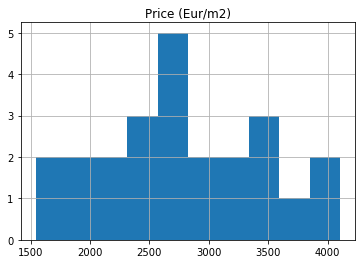

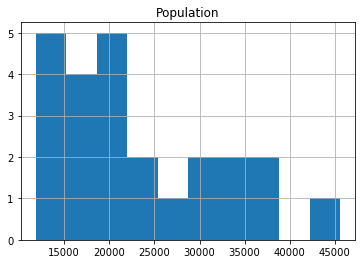

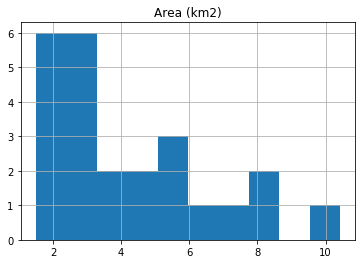

In [13]:
lisbon_grouped_reduced[['Price (Eur/m2)']].hist(bins=10)
lisbon_grouped_reduced[['Population']].hist(bins=10)
lisbon_grouped_reduced[['Area (km2)']].hist(bins=10)


In [14]:
lisbon_grouped_reduced.sum(axis=0)

Neighborhood Name                    AjudaAlcantaraAlvaladeAreeiroArroiosAvenidas N...
Price (Eur/m2)                                                                   66522
Population                                                                      552700
Population dens. (km-2)                                                         158592
Area (km2)                                                                      100.04
Shopping                                                                            80
Food and drink                                                                     604
Arts, entertainment and nightlife                                                  113
Athletics and sports                                                                30
Transport                                                                           13
Outdoors                                                                            22
Hotels and accomodation                    

## Perform k-means to check the effect on the data

### Select optimal number of clusters

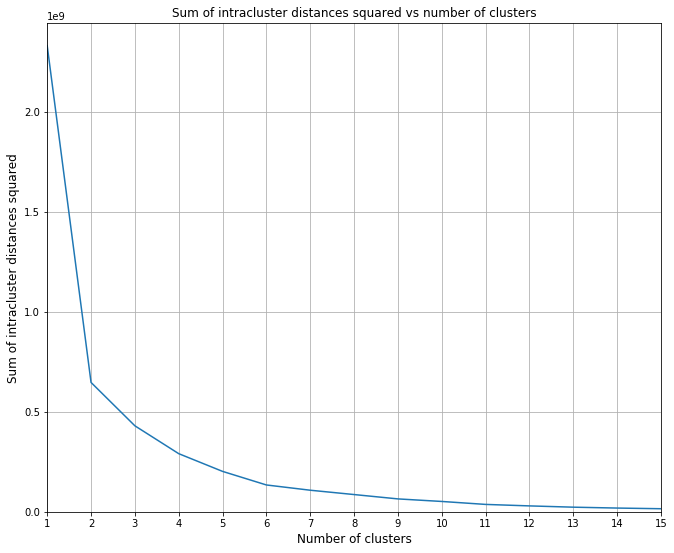

In [15]:
# Set max number of clusters
kclusters_max = 16
lisbon_grouped_reduced_clustering = lisbon_grouped_reduced.copy()
lisbon_grouped_reduced_clustering = lisbon_grouped_reduced_clustering.drop('Neighborhood Name', 1)
results = {}
results['kclusters'] = []
results['Inertia'] = []

for k in range(1,kclusters_max):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(lisbon_grouped_reduced_clustering)
    results['kclusters'].append(k)
    results['Inertia'].append(kmeans.inertia_)
    
df_results = pd.DataFrame(data=results)
ax=df_results.plot(
    x='kclusters',
    y='Inertia',
    figsize=(11, 9),
    xticks=df_results['kclusters'],
    legend=False,
    grid=True
)

ax.set_title('Sum of intracluster distances squared vs number of clusters')
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('Sum of intracluster distances squared', fontsize=12)
ax.set_ylim(bottom=0)

plt.show()

In [16]:
# Set number of optimal clusters
kclusters_opt = 3
print('Optimal number of clusters is {}.'.format(kclusters_opt))

Optimal number of clusters is 3.


### Cluster data for optimal number of clusters

In [17]:
# Set number of clusters
kclusters = kclusters_opt

lisbon_grouped_reduced_clustering = lisbon_grouped_reduced.copy()
lisbon_grouped_reduced_clustering = lisbon_grouped_reduced_clustering.drop('Neighborhood Name', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lisbon_grouped_reduced_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 1, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 0, 0, 0, 2, 2,
       1, 2])

In [18]:
# add clustering labels
lisbon_grouped_reduced_clustering_extended = lisbon_grouped_reduced_clustering.copy()
lisbon_grouped_reduced_clustering_extended.insert(0, 'Longitude', df_lisbon['Longitude'])
lisbon_grouped_reduced_clustering_extended.insert(0, 'Latitude', df_lisbon['Latitude'])
try:
    lisbon_grouped_reduced_clustering_extended.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
lisbon_grouped_reduced_clustering_extended.insert(0, 'Neighborhood Name', df_lisbon['Neighborhood'])

lisbon_grouped_reduced_clustering_extended.head()

,Neighborhood Name,Cluster Labels,Latitude,Longitude,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
0,Ajuda,2,38.707500,-9.198333,2564,15617,5422,2.88,1,5,1,0,0,1,0,0,1,0,0
1,Alcantara,2,38.706389,-9.174167,2413,13943,2750,5.07,0,13,3,0,0,1,0,2,1,0,1
2,Alvalade,1,38.746944,-9.136111,3087,31813,5957,5.34,7,20,3,1,0,1,2,1,0,1,0
3,Areeiro,0,38.740278,-9.128056,2701,20131,11569,1.74,6,10,0,4,0,0,3,1,0,0,0
4,Arroios,1,38.728889,-9.138889,2793,31653,14860,2.13,0,22,2,2,0,1,6,0,0,0,2


In [19]:
boroughs_custers = lisbon_grouped_reduced_clustering_extended[['Neighborhood Name','Cluster Labels']]
boroughs_custers

,Neighborhood Name,Cluster Labels
0,Ajuda,2
1,Alcantara,2
2,Alvalade,1
3,Areeiro,0
4,Arroios,1
5,Avenidas Novas,0
6,Beato,2
7,Belem,2
8,Benfica,1
9,Campo de Ourique,0


### Visualize clusters on a map

In [20]:
# create map
latitude = 38.736946
longitude = -9.142685
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
d=lisbon_grouped_reduced_clustering_extended.copy()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1.5, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(d['Latitude'], d['Longitude'], d['Neighborhood Name'], d['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# Legend
#list(set(d['Cluster Labels'].to_list()))
for k in range(0,kclusters_opt):
    print('Cluster {}: colour {}'.format(k+1, rainbow[k-1]))
       
map_clusters

Cluster 1: colour #ff0000
Cluster 2: colour #8000ff
Cluster 3: colour #ffb360


### Examine clusters

#### Cluster 1

In [21]:
d=lisbon_grouped_reduced_clustering_extended
d.loc[d['Cluster Labels'] == 0, d.columns[[4] + list(range(5, d.shape[1]))]]

,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
3,2701,20131,11569,1.74,6,10,0,4,0,0,3,1,0,0,0
5,3338,21625,7232,2.99,8,52,8,2,0,2,8,1,0,0,3
9,3095,22120,13406,1.65,2,29,3,1,1,1,0,1,0,0,2
11,2745,19218,5208,3.69,0,21,1,0,0,1,0,0,1,0,0
12,3472,20128,4375,4.60,5,18,2,2,0,2,2,0,0,0,1
17,3496,21025,3864,5.44,16,57,13,4,2,3,3,1,0,0,0
18,2285,27967,10319,2.71,2,34,2,1,0,2,9,1,0,0,5
19,1780,22480,6690,3.36,0,3,0,0,2,0,0,0,0,0,0


#### Cluster 2

In [28]:
out=0
if kclusters >= 2:
    d=lisbon_grouped_reduced_clustering_extended
    out = d.loc[d['Cluster Labels'] == 1, d.columns[[4] + list(range(5, d.shape[1]))]]
else:
    print('Cluster not available.')
out

,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
2,3087,31813,5957,5.34,7,20,3,1,0,1,2,1,0,1,0
4,2793,31653,14860,2.13,0,22,2,2,0,1,6,0,0,0,2
8,2205,36985,4605,8.03,2,29,2,1,0,2,0,0,0,2,2
13,2469,45605,6941,6.57,1,19,1,7,0,0,0,1,0,0,2
14,1543,37793,5308,7.12,2,11,2,0,1,0,0,0,0,0,0
16,1860,33788,4176,8.09,1,5,0,0,1,0,1,0,0,0,1
22,2737,33043,7702,4.29,1,8,6,0,2,1,0,1,0,0,0


#### Cluster 3

In [29]:
out=0
if kclusters >= 3:
    d=lisbon_grouped_reduced_clustering_extended
    out = d.loc[d['Cluster Labels'] == 2, d.columns[[4] + list(range(5, d.shape[1]))]]
else:
    print('Cluster not available.')
out

,Price (Eur/m2),Population,Population dens. (km-2),Area (km2),Shopping,Food and drink,"Arts, entertainment and nightlife",Athletics and sports,Transport,Outdoors,Hotels and accomodation,Public buildings,Historic sites and museums,Health and education buildings,Supermarkets and groceries
0,2564,15617,5422,2.88,1,5,1,0,0,1,0,0,1,0,0
1,2413,13943,2750,5.07,0,13,3,0,0,1,0,2,1,0,1
6,1913,12737,5177,2.46,0,7,0,0,0,0,0,0,1,0,0
7,2877,16528,1584,10.43,1,35,3,0,2,3,3,2,3,0,0
10,2633,15460,5581,2.77,9,26,3,2,0,0,3,0,0,0,0
15,3894,13044,5956,2.19,3,52,34,0,1,0,9,1,0,0,0
20,3632,12822,4259,3.01,5,55,16,0,0,0,15,4,4,0,1
21,4105,11836,7943,1.49,7,57,4,2,1,0,26,1,0,1,1
23,2885,15339,7708,1.99,1,16,4,1,0,1,0,1,0,0,0


#### Cluster 4

In [30]:
out=0
if kclusters >= 4:
    d=lisbon_grouped_reduced_clustering_extended
    out = d.loc[d['Cluster Labels'] == 3, d.columns[[4] + list(range(5, d.shape[1]))]]
else:
    print('Cluster not available.')
out

Cluster not available.


0

#### Cluster 5

In [31]:
out=0
if kclusters >= 5:
    d=lisbon_grouped_reduced_clustering_extended
    out = d.loc[d['Cluster Labels'] == 4, d.columns[[4] + list(range(5, d.shape[1]))]]
else:
    print('Cluster not available.')
out

Cluster not available.


0

#### Cluster centers

In [32]:
centers = kmeans.cluster_centers_
df_dic = {}
df_dic['Features'] = list(lisbon_grouped_reduced_clustering.columns)

for k in range(0,kclusters):
    s='Cluster center {}'.format(k+1)
    df_dic[s] = centers[k].tolist()
    
df_centers = pd.DataFrame(data=df_dic)
df_centers

,Features,Cluster center 1,Cluster center 2,Cluster center 3
0,Price (Eur/m2),2864.0000,2.384857e+03,2990.666667
1,Population,21836.7500,3.581143e+04,14147.333333
2,Population dens. (km-2),7832.8750,7.078429e+03,5153.333333
3,Area (km2),3.2725,5.938571e+00,3.587778
4,Shopping,4.8750,2.000000e+00,3.000000
5,Food and drink,28.0000,1.628571e+01,29.555556
6,"Arts, entertainment and nightlife",3.6250,2.285714e+00,7.555556
7,Athletics and sports,1.7500,1.571429e+00,0.555556
8,Transport,0.6250,5.714286e-01,0.444444
9,Outdoors,1.3750,7.142857e-01,0.666667


## Determine correlation factors

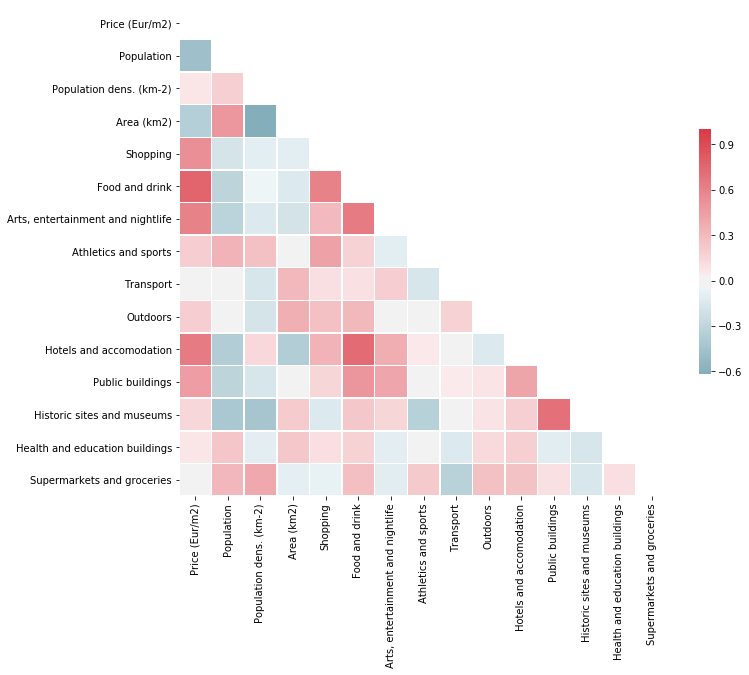

In [33]:
# Compute the correlation matrix
corr = lisbon_grouped_reduced.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
# Order by descending absolute values
corr_price = corr['Price (Eur/m2)'].drop(labels=['Price (Eur/m2)'])
corr_price_abs = abs(corr_price)
corr_price_abs_sorted = corr_price_abs.sort_values(ascending = False)
corr_price_abs_sorted

Food and drink                       0.767761
Hotels and accomodation              0.644956
Arts, entertainment and nightlife    0.605600
Shopping                             0.534702
Population                           0.465174
Public buildings                     0.457006
Area (km2)                           0.356242
Outdoors                             0.204509
Athletics and sports                 0.194633
Historic sites and museums           0.147068
Health and education buildings       0.069651
Population dens. (km-2)              0.065371
Transport                            0.020419
Supermarkets and groceries           0.008348
Name: Price (Eur/m2), dtype: float64

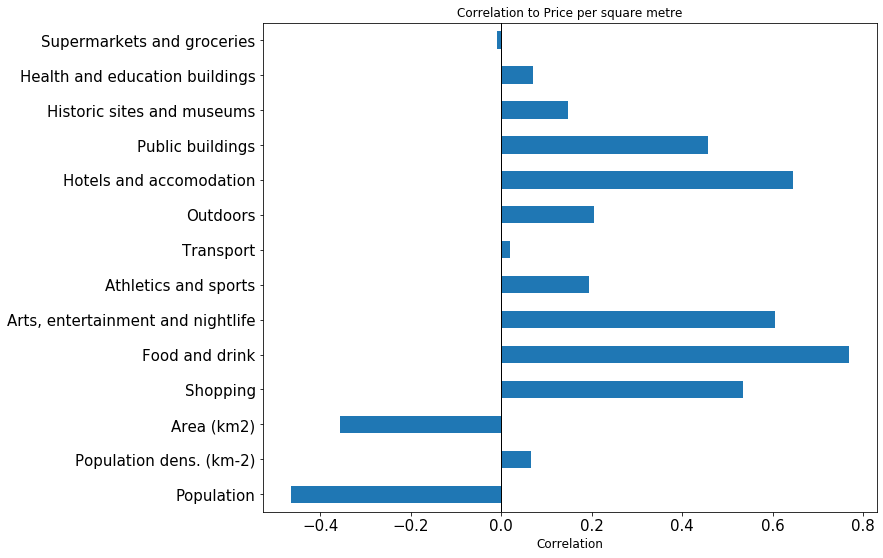

In [35]:
# Plot the correlation index
f, ax = plt.subplots(figsize=(11, 9))
ax.axvline(0, color='black', lw=1)
ax.set_xlabel('Correlation', fontsize=12)
corr_price.plot.barh(ax=ax, grid=False, title='Correlation to Price per square metre', fontsize=15)

## Perform multiple linear regression

### Determine number of features to include

In [36]:
features_list_desc = list(corr_price_abs_sorted.keys())

# Keep adding next feature with highest correlation
R2 = []
for i in range(0,len(features_list_desc)):
    # Get full x and y
    y = lisbon_grouped_reduced[['Price (Eur/m2)']]
    x = lisbon_grouped_reduced[features_list_desc[0:i+1]]
    
    #print(features_list_desc[i:i+1])
    
    # Divide data into test and train subsets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

    # Fit model
    regr = linear_model.LinearRegression()
    regr.fit (X_train, y_train)

    # Explained variance score (R^2)
    R2.append((i+1, regr.score(X_test, y_test)))


labels = ['NumberFeatures', 'R2']
df_R2 = pd.DataFrame.from_records(R2, columns=labels)
df_R2


,NumberFeatures,R2
0,1,0.578216
1,2,0.582691
2,3,0.583993
3,4,0.474378
4,5,0.539545
5,6,0.420210
6,7,0.443671
7,8,0.526513
8,9,0.732333
9,10,0.696861


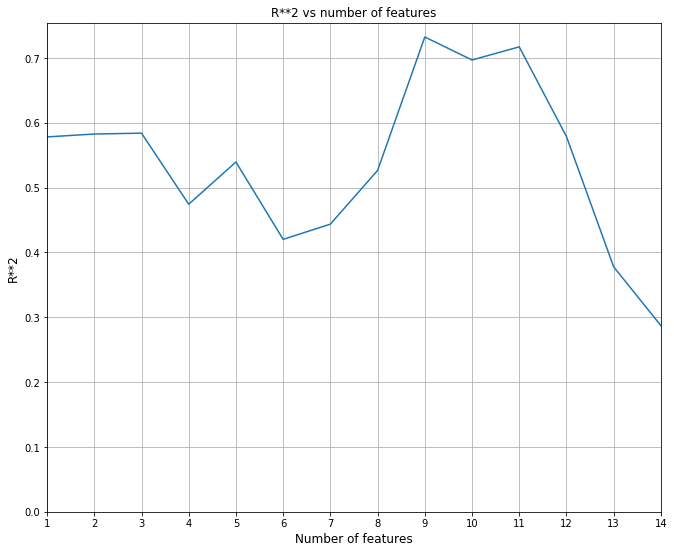

In [31]:
ax=df_R2.plot(
    x='NumberFeatures',
    y='R2',
    figsize=(11, 9),
    xticks=df_R2['NumberFeatures'],
    legend=False,
    grid=True
)

ax.set_title('R**2 vs number of features')
ax.set_xlabel('Number of features', fontsize=12)
ax.set_ylabel('R**2', fontsize=12)
ax.set_ylim(bottom=0)

plt.show()

In [37]:
# Get number of features that maximizes R2
N_feat = int(df_R2.loc[df_R2['R2'] == df_R2['R2'].max()].NumberFeatures.to_numpy()[0])
print('Number of features: {} '.format(N_feat))

Number of features: 9 


### Fit model for determined number of features

In [38]:
features_list_desc = list(corr_price_abs_sorted.keys())

# Set number of features to be considered
N = N_feat

# Get full x and y
y = lisbon_grouped_reduced[['Price (Eur/m2)']]
x = lisbon_grouped_reduced[features_list_desc[0:N]]

# Divide data into test and train subsets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Fit model
regr = linear_model.LinearRegression()
regr.fit (X_train, y_train)

# Explained variance score (R^2)
R2 = regr.score(X_test, y_test)
print('Explained variance (R^2): {:.3f}'.format(R2))

Explained variance (R^2): 0.732


### Predict data

In [39]:
y_test_pred = regr.predict(X_test) 
y_train_pred = regr.predict(X_train) 

### Print coefficients

In [40]:
regr.coef_ # Get the coefficients, beta

array([[-4.08046302e+00,  4.44690718e+01,  3.45040640e+01,
         2.84188325e+01, -1.41164500e-02,  1.10146488e+02,
        -2.33757594e+01,  1.48140625e+02,  8.45804325e+01]])

In [41]:
regr.intercept_ # Get the intercept, c

array([2559.85583073])

### Plot residuals

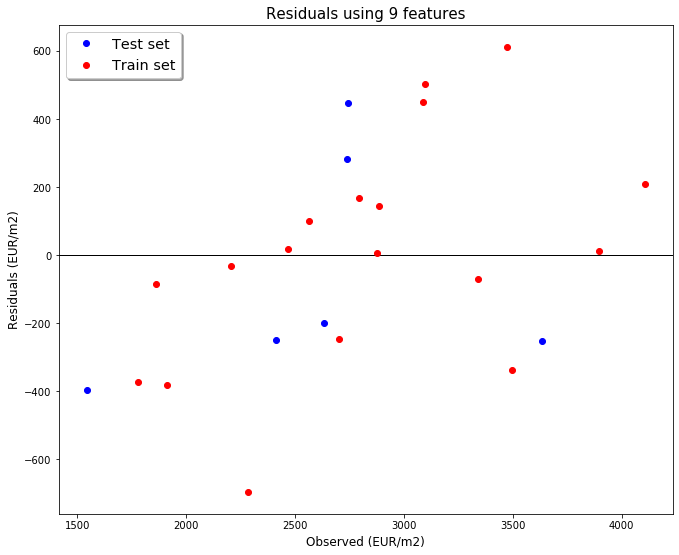

In [42]:
# Calculate residuals
resid_test = y_test - y_test_pred
resid_train = y_train - y_train_pred

# plot prediction and actual data
f, ax = plt.subplots(figsize=(11, 9))
ax.axhline(0, color='black', lw=1)
ax.set_title('Residuals using {} features'.format(N_feat), fontsize=15)
ax.set_xlabel('Observed (EUR/m2)', fontsize=12)
ax.set_ylabel('Residuals (EUR/m2)', fontsize=12)

ax.plot(y_test, resid_test, 'bo', label='Test set')
ax.plot(y_train, resid_train, 'ro', label='Train set')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

### Plot predicted and observed data

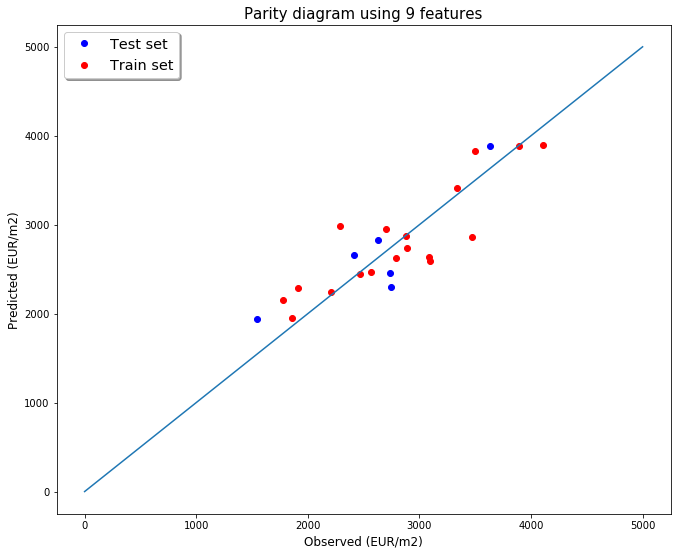

In [43]:
# plot prediction and actual data
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Parity diagram using {} features'.format(N_feat), fontsize=15)
ax.set_xlabel('Observed (EUR/m2)', fontsize=12)
ax.set_ylabel('Predicted (EUR/m2)', fontsize=12)
ax.plot(y_test, y_test_pred, 'bo', label='Test set')
ax.plot(y_train, y_train_pred, 'ro', label='Train set')

# plot identity line
x = np.linspace(0, 5000, 100)
y = x
ax.plot(x, y)
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()